In [51]:
import zipfile
import requests 
import numpy as np
import pandas as pd 
import io
import matplotlib.pyplot as plt


In [3]:
#Download the zip file from the URL
url = 'https://archive.ics.uci.edu/static/public/222/bank+marketing.zip'  
response = requests.get(url)

In [4]:
with zipfile.ZipFile(io.BytesIO(response.content)) as first_folder:
    # List all files in the zip
    print("Files in first folder:", first_folder.namelist()) 
    # Extract 'bank.zip' (the inner zip file)
    with first_folder.open('bank.zip') as bank_zip_file:
        # Read the 'bank.zip' (the inner zip file)
        with zipfile.ZipFile(io.BytesIO(bank_zip_file.read())) as inner_zip:
            # List all files in 'bank.zip' to locate 'bank-full.csv'
            print("Files in bank.zip:", inner_zip.namelist())
            # Extract 'bank-full.csv' from the inner zip
            with inner_zip.open('bank-full.csv') as csv_file:
                # Step 4: Read the CSV file into a DataFrame
                df = pd.read_csv(csv_file, delimiter=";")

Files in first folder: ['bank.zip', 'bank-additional.zip']
Files in bank.zip: ['bank-full.csv', 'bank-names.txt', 'bank.csv']


# Start of Homework 4

In [5]:
# Doesn't look like there are any missing values 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [5]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [6]:
# use only the columns in the homework 
cols = ['age', 'job', 'marital', 'education','balance', 'housing','contact', 'day', 
        'month', 'duration', 'campaign', 'pdays','previous', 'poutcome', 'y']
df_hw = df[cols]

In [76]:
from sklearn.model_selection import train_test_split
# Assuming your column is named 'your_column'
df_hw['y'] = df_hw['y'].replace({'yes': 1, 'no': 0})

# Create train and test out of the dataset
df_train_full, df_test = train_test_split(df_hw, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.y.values
y_train_full = df_train_full.y.values
y_val = df_val.y.values
y_test = df_test.y.values

del df_train['y']
del df_val['y']
del df_test['y']

/tmp/ipykernel_6133/3351486265.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hw['y'] = df_hw['y'].replace({'yes': 1, 'no': 0})


### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `balance`
- `day`
- `duration`
- `previous`


In [24]:
from sklearn.metrics import roc_auc_score, auc
# Create categorical vs numerical columns 
cats = ['job', 'marital', 'education', 'housing','contact','month','poutcome']
num = ['age', 'balance', 'day',  'duration', 'campaign', 'pdays','previous']

for i in num:
    print(f"The {i} column gives an AUC score of {roc_auc_score(y_train, df_train[i].values)}")

The age column gives an AUC score of 0.48781428247265596
The balance column gives an AUC score of 0.5888313805382317
The day column gives an AUC score of 0.474042117616092
The duration column gives an AUC score of 0.8147002759670778
The campaign column gives an AUC score of 0.42854569843178414
The pdays column gives an AUC score of 0.5901276247352144
The previous column gives an AUC score of 0.5985653242764153


### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.69
- 0.79
- 0.89
- 0.99



In [26]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [37]:
unique, counts = np.unique(y_val, return_counts=True)
print(np.asarray((unique, counts)).T)

[[   0 7944]
 [   1 1098]]


In [ ]:
dict_vec = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dict_vec.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dict_vec.transform(val_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

model.fit(X_train,y_train)

In [40]:
# Check accuracy of model by pulling predicted labels and then calculate the auc scores
y_pred_proba = model.predict_proba(X_val)[:,1]
auc_score = roc_auc_score(y_val, y_pred_proba)
auc_score

np.float64(0.9004159581551736)

### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.265
* 0.465
* 0.665
* 0.865



In [46]:
y_pred

array([[0.9700387 , 0.0299613 ],
       [0.97687061, 0.02312939],
       [0.97922592, 0.02077408],
       ...,
       [0.75171456, 0.24828544],
       [0.99781261, 0.00218739],
       [0.96219338, 0.03780662]])

In [49]:
# Do this bullshit like they do in the videos
thresholds = np.linspace(0, 1, 101)

precisions = []
recalls = []

actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

for t in thresholds:
    predict_positive = (y_pred_proba >= t)
    predict_negative = (y_pred_proba < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    # Avoid division by zero in precision
    if tp + fp == 0:
        precision = 0  # If there are no predicted positives, precision is 0
    else:
        precision = tp / (tp + fp)

    recall = tp / (tp + fn) if tp + fn != 0 else 0  # Avoid division by zero in recall
    
    precisions.append(precision)
    recalls.append(recall)

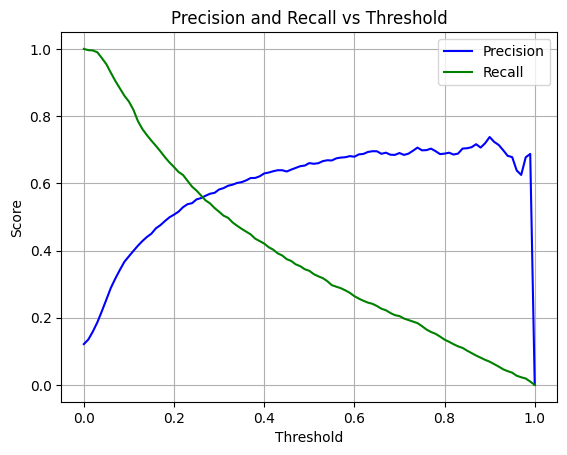

In [52]:
plt.plot(thresholds, precisions, label='Precision', color='b')
plt.plot(thresholds, recalls, label='Recall', color='g')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.02
- 0.22
- 0.42
- 0.62

In [68]:
precisions = np.array(precisions)
recalls = np.array(recalls)
f1_scores = 2*((precisions*recalls)/(precisions+recalls))

/tmp/ipykernel_6133/3603231193.py:3: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2*((precisions*recalls)/(precisions+recalls))


In [69]:

for index,value in enumerate(np.linspace(0, 1, 101)):
    print(f"For the threshold at {value}, the F1 Score is: {f1_scores[index]}")

For the threshold at 0.0, the F1 Score is: 0.2165680473372781
For the threshold at 0.01, the F1 Score is: 0.23792953458025232
For the threshold at 0.02, the F1 Score is: 0.27393483709273186
For the threshold at 0.03, the F1 Score is: 0.3137085137085137
For the threshold at 0.04, the F1 Score is: 0.3580288300368756
For the threshold at 0.05, the F1 Score is: 0.401378782075833
For the threshold at 0.06, the F1 Score is: 0.4408904257618327
For the threshold at 0.07, the F1 Score is: 0.46939257858662253
For the threshold at 0.08, the F1 Score is: 0.49350649350649345
For the threshold at 0.09, the F1 Score is: 0.514145810663765
For the threshold at 0.1, the F1 Score is: 0.5265851578049474
For the threshold at 0.11, the F1 Score is: 0.5363961813842482
For the threshold at 0.12, the F1 Score is: 0.5424795468848332
For the threshold at 0.13, the F1 Score is: 0.5481967213114755
For the threshold at 0.14, the F1 Score is: 0.5530328702134871
For the threshold at 0.15, the F1 Score is: 0.556097560

#### For the threshold at 0.02, the F1 Score is: 0.27393483709273186
#### For the threshold at 0.22, the F1 Score is: 0.5728601252609603
#### For the threshold at 0.42, the F1 Score is: 0.4930284439486894
#### For the threshold at 0.62, the F1 Score is: 0.36715620827770357

### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.26

In [73]:
from sklearn.model_selection import KFold
k_fold = KFold(n_splits=5, shuffle=True, random_state=1)
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

# initialize empty list for auc scores
auc_scores = []

In [80]:
# Iterate over the folds
for train_idx, val_idx in k_fold.split(df_train_full):
    # Split the dataset into training and validation sets
    df_train = df_train_full.iloc[train_idx]
    df_val = df_train_full.iloc[val_idx]
    # Grab the target variables
    y_train = df_train.y.values
    y_val = df_val.y.values
    # create dictionary vectorizer for our data and drop the y variable
    dict_vec = DictVectorizer(sparse=False)
    train_dict = df_train.drop(columns=['y']).to_dict(orient='records')
    val_dict = df_val.drop(columns=['y']).to_dict(orient='records')
    # fit vectorizer over data 
    X_train = dict_vec.fit_transform(train_dict)
    X_val = dict_vec.transform(val_dict)
    # train the model
    model.fit(X_train, y_train)
    # Get the predicted probabilities for the positive class
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    # Compute the AUC score
    auc = roc_auc_score(y_val, y_pred_proba)
    # Store the AUC score for this fold
    auc_scores.append(auc)


In [82]:
mean_auc = np.mean(auc_scores)
std_auc = np.std(auc_scores)

print(f'AUC scores across 5 folds: {auc_scores}')
print(f'Mean AUC: {mean_auc:.3f}')
print(f'Standard deviation of AUC: {std_auc:.3f}')

AUC scores across 5 folds: [np.float64(0.8992842405563055), np.float64(0.8990110164487815), np.float64(0.9111641244449282), np.float64(0.9078905031338849), np.float64(0.9119728949040351)]
Mean AUC: 0.906
Standard deviation of AUC: 0.006


### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.


In [85]:
from tqdm.auto import tqdm

In [90]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[cats + num].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df[cats + num].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [91]:
n_splits = 5

for C in [0.000001, 0.001, 1]:
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        y_train = df_train.y.values
        y_val = df_val.y.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=1e-06 0.701 +- 0.009
C=0.001 0.861 +- 0.007
C=1 0.906 +- 0.006
